In [84]:
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [85]:
import os 
while 'notebooks' in os.getcwd():
    os.chdir("..")
    
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import csv
from tqdm import tqdm
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from scipy import stats

import warnings
warnings.filterwarnings("ignore")
from src.constants import CLEANED_HOUSEHOLD_POWER_PATH, CLEANED_WEATHER_PATH, \
    HOUSEHOLD_WEATHER_MERGED_PATH

## Hourly distribution

In [86]:
df = pd.read_pickle(
    HOUSEHOLD_WEATHER_MERGED_PATH    
)

house_consumpion_columns = [
    'global_active_power', 
    'global_reactive_power', 
    'voltage',
    'global_intensity', 
    'sub_metering_1', 
    'sub_metering_2',
    'sub_metering_3'
]

df.head()

,global_active_power,global_reactive_power,voltage,global_intensity,sub_metering_1,sub_metering_2,sub_metering_3,numer_sta,pmer,tend,...,phenspe1,phenspe2,phenspe3,nnuage1,ctype1,hnuage1,Nom,Latitude,Longitude,Altitude
date,,,,,,,,,,,,,,,,,,,,,
2007-01-01 00:00:00,2.580,0.136,241.97,10.6,0.0,0.0,0.0,7149.0,101960.0,-70.0,...,1017.0,710.0,1118.0,2.0,8.0,780.0,ORLY,48.716833,2.384333,89.0
2007-01-01 00:01:00,2.552,0.100,241.75,10.4,0.0,0.0,0.0,7149.0,101960.0,-70.0,...,1017.0,710.0,1118.0,2.0,8.0,780.0,ORLY,48.716833,2.384333,89.0
2007-01-01 00:02:00,2.550,0.100,241.64,10.4,0.0,0.0,0.0,7149.0,101960.0,-70.0,...,1017.0,710.0,1118.0,2.0,8.0,780.0,ORLY,48.716833,2.384333,89.0
2007-01-01 00:03:00,2.550,0.100,241.71,10.4,0.0,0.0,0.0,7149.0,101960.0,-70.0,...,1017.0,710.0,1118.0,2.0,8.0,780.0,ORLY,48.716833,2.384333,89.0
2007-01-01 00:04:00,2.554,0.100,241.98,10.4,0.0,0.0,0.0,7149.0,101960.0,-70.0,...,1017.0,710.0,1118.0,2.0,8.0,780.0,ORLY,48.716833,2.384333,89.0


In [87]:
consumption_df = df[house_consumpion_columns]
consumption_df.head()

,global_active_power,global_reactive_power,voltage,global_intensity,sub_metering_1,sub_metering_2,sub_metering_3
date,,,,,,,
2007-01-01 00:00:00,2.580,0.136,241.97,10.6,0.0,0.0,0.0
2007-01-01 00:01:00,2.552,0.100,241.75,10.4,0.0,0.0,0.0
2007-01-01 00:02:00,2.550,0.100,241.64,10.4,0.0,0.0,0.0
2007-01-01 00:03:00,2.550,0.100,241.71,10.4,0.0,0.0,0.0
2007-01-01 00:04:00,2.554,0.100,241.98,10.4,0.0,0.0,0.0


### Normality test

In [88]:
def ks_test(x : pd.Series):
    if len(x) == 0:
        return np.nan
    
    mu = x.mean()
    std = x.std()

    return stats.kstest((x - mu)/std, stats.norm.cdf)

In [89]:
test_results = consumption_df['global_active_power']\
    .groupby(pd.Grouper(freq="1H"))\
    .apply(ks_test)

In [90]:
test_results_df = test_results.apply(
    lambda x: (np.nan, np.nan) if np.isnan(x).any() else (x.statistic, x.pvalue)
)

test_results_df = pd.DataFrame(
    test_results_df.to_list(), 
    columns = ['statistic', 'pvalue'],
    index = test_results.index    
)

In [102]:
def get_weekend_feature(df:pd.DataFrame):
    day_of_week = df.index.day_of_week
    is_weekend = (day_of_week == 5) | (day_of_week ==6)
    df['is_weekend'] = is_weekend.astype(float)

    return df

In [103]:
test_results_df = test_results_df.dropna()
test_results_df = get_weekend_feature(test_results_df)

In [107]:
test_results_df.groupby("is_weekend").apply(
    lambda x: (x['pvalue'] > 5e-2).sum()/len(x)
)

is_weekend
0.0    0.153771
1.0    0.160099
dtype: float64

In [104]:
test_results_df.pvalue.max(), test_results_df.pvalue.argmax()

(0.9981228309247663, 16334)

<Axes: xlabel='date'>

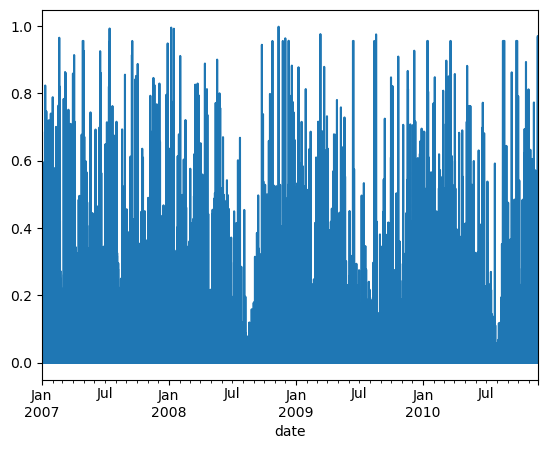

In [93]:
test_results_df.pvalue.plot()

In [94]:
(test_results_df.dropna().pvalue < 5e-2).sum()/len(test_results_df)

0.84442756121793

In [95]:
test_results_df.index

DatetimeIndex(['2007-01-01 00:00:00', '2007-01-01 01:00:00',
               '2007-01-01 02:00:00', '2007-01-01 03:00:00',
               '2007-01-01 04:00:00', '2007-01-01 05:00:00',
               '2007-01-01 06:00:00', '2007-01-01 07:00:00',
               '2007-01-01 08:00:00', '2007-01-01 09:00:00',
               ...
               '2010-11-26 12:00:00', '2010-11-26 13:00:00',
               '2010-11-26 14:00:00', '2010-11-26 15:00:00',
               '2010-11-26 16:00:00', '2010-11-26 17:00:00',
               '2010-11-26 18:00:00', '2010-11-26 19:00:00',
               '2010-11-26 20:00:00', '2010-11-26 21:00:00'],
              dtype='datetime64[ns]', name='date', length=34222, freq='H')

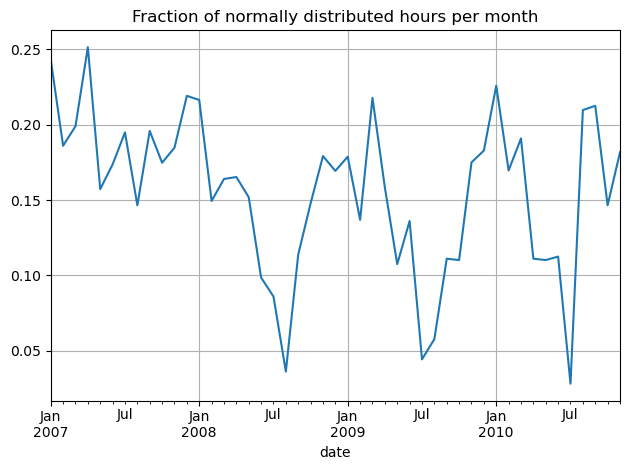

In [100]:

ax = (test_results_df.dropna().pvalue > 0.05).groupby(
        pd.Grouper(freq="1M")
    ).apply(lambda x: x.sum()/len(x))\
    .plot(
        title="Fraction of normally distributed hours per month"
    )
plt.axvline(
    pd.to_datetime('2009-01-01'),
    axes = ax
)



plt.tight_layout()
plt.grid()
plt.savefig("img/normal_per_hour.png")
plt.show()

In [14]:
test_results_df


,statistic,pvalue
date,,
2007-01-01 00:00:00,0.185424,2.804493e-02
2007-01-01 01:00:00,0.232202,2.505551e-03
2007-01-01 02:00:00,0.102275,5.235479e-01
2007-01-01 03:00:00,0.172395,4.980976e-02
2007-01-01 04:00:00,0.121582,3.119715e-01
...,...,...
2010-11-26 17:00:00,0.381057,2.419603e-08
2010-11-26 18:00:00,0.253140,7.086527e-04
2010-11-26 19:00:00,0.143677,1.521587e-01


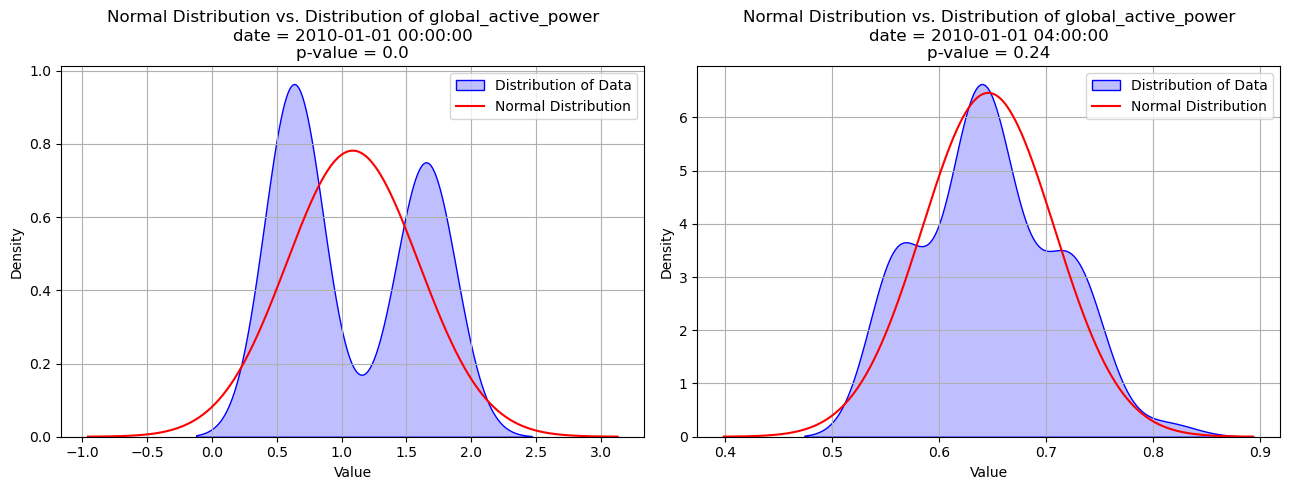

In [16]:

from scipy.stats import norm
iterator = iter(consumption_df.groupby(pd.Grouper(freq="1H")))

date, df1 = next(iterator)
p_value = test_results_df.loc[date]['pvalue']
while date < pd.Timestamp('2010') or p_value > 0.05:

    date, df1 = next(iterator)
    p_value = test_results_df.loc[date]['pvalue']

p_value = test_results_df.loc[date]['pvalue']

column = 'global_active_power'
series = df1[column]

# Calculate the mean and standard deviation
mean = series.mean()
std = series.std()

# Create a range of values for plotting the theoretical normal distribution
x = np.linspace(mean - 4*std, mean + 4*std, 1000)
y = norm.pdf(x, mean, std)  # PDF of the normal distribution

# Start plotting
fig, axs = plt.subplots(1, 2, figsize=(13, 5))

# Plot the distribution of data
sns.kdeplot(series, color="blue", label="Distribution of Data", fill=True, ax=axs[0])

# Plot the normal distribution
axs[0].plot(x, y, color="red", label="Normal Distribution")

# Plot details
axs[0].set_title(f'Normal Distribution vs. Distribution of {column}\ndate = {date}\np-value = {round(p_value, 2)}')
axs[0].set_xlabel('Value')
axs[0].set_ylabel('Density')
axs[0].legend()
axs[0].grid(True)

date, df1 = next(iterator)
p_value = test_results_df.loc[date]['pvalue']
while date < pd.Timestamp('2009') or p_value < 0.05:

    date, df1 = next(iterator)
    p_value = test_results_df.loc[date]['pvalue']


p_value = test_results_df.loc[date]['pvalue']

column = 'global_active_power'
series = df1[column]

# Calculate the mean and standard deviation
mean = series.mean()
std = series.std()

# Create a range of values for plotting the theoretical normal distribution
x = np.linspace(mean - 4*std, mean + 4*std, 1000)
y = norm.pdf(x, mean, std)  # PDF of the normal distribution

# Plot the distribution of data
sns.kdeplot(series, color="blue", label="Distribution of Data", fill=True, ax=axs[1])

# Plot the normal distribution
axs[1].plot(x, y, color="red", label="Normal Distribution")

# Plot details
axs[1].set_title(f'Normal Distribution vs. Distribution of {column}\ndate = {date}\np-value = {round(p_value, 2)}')
axs[1].set_xlabel('Value')
axs[1].set_ylabel('Density')
axs[1].legend()
axs[1].grid(True)


# Save the plot
plt.tight_layout()
plt.savefig("img/normality_test.png")

# Show the plot
plt.show()

## Comparing between hours in a day

In [35]:
test_results_df.index.strftime('%H:%M:%S')

Index(['00:00:00', '01:00:00', '02:00:00', '03:00:00', '04:00:00', '05:00:00',
       '06:00:00', '07:00:00', '08:00:00', '09:00:00',
       ...
       '12:00:00', '13:00:00', '14:00:00', '15:00:00', '16:00:00', '17:00:00',
       '18:00:00', '19:00:00', '20:00:00', '21:00:00'],
      dtype='object', name='date', length=34222)

In [37]:
index = test_results_df.index.strftime('%H:%M:%S')

In [38]:
copy_df = test_results_df.copy()
copy_df.index = index

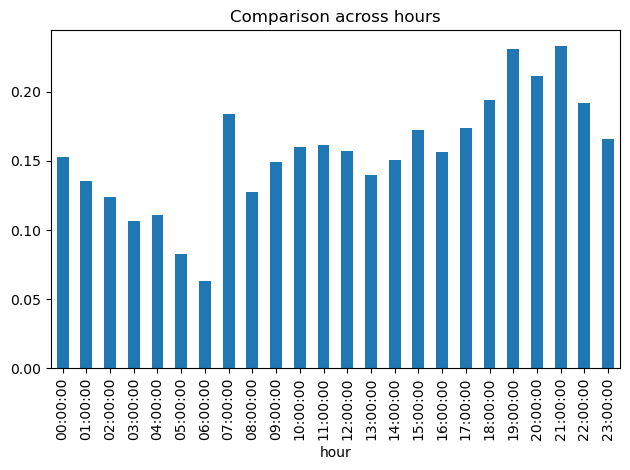

In [115]:

(copy_df.pvalue > 5e-2)\
    .groupby(level="date")\
    .apply(lambda x: x.sum()/len(x))\
    .plot(kind = 'bar')

plt.title("Comparison across hours")
plt.xlabel("hour")
plt.tight_layout()
plt.savefig("img/normal_across_hours.png")

In [17]:
batches = consumption_df['global_active_power'].groupby(
    pd.Grouper(freq = '1H')
)\
    .mean()\
    .groupby(
        pd.Grouper(freq = '1D')
    )

In [18]:
iterator = iter(batches)

Text(0.5, 1.0, 'Hourly consumption on a day- Monday, 08/01/2007')

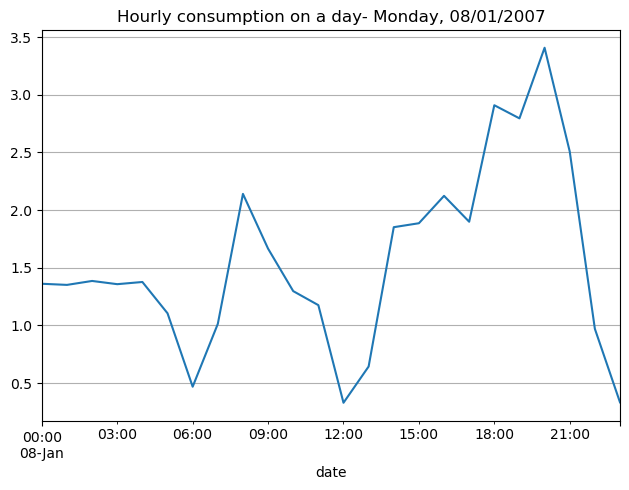

In [26]:
daily_data =next(iterator) 

day_of_the_week = daily_data[0].strftime("%A") 
data_str = daily_data[0].strftime("%d/%m/%Y") 

daily_data[1].plot()
plt.grid()
plt.tight_layout()
plt.title(f"Hourly consumption on a day- {day_of_the_week}, {data_str}")